# Converting coordinates to different projected coordinates

> history \| Create July 2023 <br/>

<a href="https://polarwatch.noaa.gov/" target="_blank">NOAA PolarWatch</a> distributes gridded and tabular oceanographic data for polar regions.  Satellite data include geospatial information and most of them are in geographical coordinates (latitude and longitude).  PolarWatch satellite data are often projected using <a href="https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection" target="_blank">Polar Stereographic Projections</a> in x and y coordinates.

In this exercise, we will learn to transform coordinates of one projection to another using python package (pyproj).

**The exercise demonstrates the following techniques:**
-   Accessing a netcdf file from ERDDAP file directory
-   Transforming coordinates using EPSG codes
-   Transforming coordinates using proj4str
-   Add transformed coordinates to xarray dataset


**Datasets used:**
<!-- -   sea ice data (stereographic projection) -->
-   sea ice thickness 


**Python packages used:**
-   urllib.request (data download)
-   xarray (reading and analyzing data)
-   pyproj (reprojection)
-   cartopy (projection)
-   numpy 





## Import  packages

In [61]:
import netCDF4 as nc
import cartopy.crs as ccrs
import urllib.request
import pyproj
import xarray as xr
import numpy as np
from pyproj import CRS
from pyproj import Transformer
from matplotlib import pyplot as plt 

## Antarctic Sea Ice Concentration Data

To demonstrate mapping the steoreographic projected data on the projected map, we will use NSIDC Sea Ice Concentration data from passive microwave sensors.  

**Data**

*Sea Ice Concentration*, NOAA/NSIDC Climate Data Record V4, Southern Hemisphere, 25km, Science Quality, 1978-Present, Monthly

**Brief description**  

This dataset includes sea ice concentration data from the southern hemisphere, and is produced by the NOAA/NSIDC using the Climate Data Record algorithm.  The resolution is 25km, meaning each grid in this data set represents a value that covers a 25km by 25km area.  

The time series data product includes data from 1978 to present.  The dataset we will be using for this exercise is the monthly composite, meaning data were aggregated by month.

**Userful links**

-   <a href="https://nsidc.org/data/g02202/versions/4" target="_blank">NSIDC Data Product Description</a>
-   <a href="https://nsidc.org/sites/default/files/g02202-v004-userguide_1_1.pdf" target="_blank">NSIDC Data Product User Guide (pdf)</a>
-   <a href="https://polarwatch.noaa.gov/catalog/ice-sq-nh-nsidc-cdr-v4/preview/?dataset=daily&var=cdr_seaice_conc&time_min=2022-05-31T00:00:00Z&time_max=2022-05-31T00:00:00Z&proj=epsg3413&colorBar=KT_ice|||0|1|" target="_blank">NOAA PolarWatch Data Product Page (download, preview)</a>








In [ ]:
# request datafrom polarwatch.noaa.gov errdap and save it to seaice.nc file

url="https://polarwatch.noaa.gov/erddap/griddap/nesdisSSH1day.nc?sla%5B(2023-07-29T00:00:00Z):1:(2023-07-29T00:00:00Z)%5D%5B(60):1:(89.875)%5D%5B(-179.875):1:(179.875)%5D"
urllib.request.urlretrieve(url, "seaice.nc")

In [12]:
# open and assign data from the file to a variable ds using xarray
ds = xr.open_dataset("sic.nc")

In [15]:
ds

<xarray.Dataset>
Dimensions:                  (time: 1, ygrid: 332, xgrid: 316)
Coordinates:
  * time                     (time) datetime64[ns] 2022-12-01
  * ygrid                    (ygrid) float32 4.338e+06 4.312e+06 ... -3.938e+06
  * xgrid                    (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    Conventions:                                         CF-1.6, ACDD-1.3, CO...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2022-12-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 2022-12-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

## Transforming from CRS to CRS

When transforming from one CRS to another, it is important to inspect CRS definitions for proper transformation.
We will transform from CRS EPSG: 4326 (geographic coordinate system) to EPSG: 3413 (NSIDC Polar Stereographic North). 

There are few ways to specify CRS as shown below.  For this exercise, we will use EPSG code.


```
crs = CRS.from_epsg(4326)
crs = CRS.from_string("EPSG:4326")
crs = CRS.from_proj4("+proj=latlon")
```



In [13]:
crs_4326 = CRS.from_epsg(4326)
crs_4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [51]:
crs_3031 = CRS.from_epsg(3031)
crs_3031

<Derived Projected CRS: EPSG:3031>
Name: WGS 84 / Antarctic Polar Stereographic
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Antarctica.
- bounds: (-180.0, -90.0, 180.0, -60.0)
Coordinate Operation:
- name: Antarctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Inspect CRS definitions

**crs_4326**
* order of axis: latitude first, and longitude in degree
* bounds (-180, -90, 180, 90) global coverage  

**crs_3413**
* order of axis: X then Y in meter 
* bounds (-180, 60, 180, 90)

**based on the crs definitions**
* transformation input should be in the order of latitude and longitude
* transformation input/output should be within the bounds


*NOTE: if you prefer to use lon and lat (or x, y) axis order, you can set transformer paramter **always_xy** to True*

In [54]:
# transformer converts lon and lat values to x, y 

transformer = Transformer.from_crs(crs_3031, crs_4326)
#ransformer.transform(80, 180)  #LAT, LON
# ny, nx = ds['sla'][0][:].shape

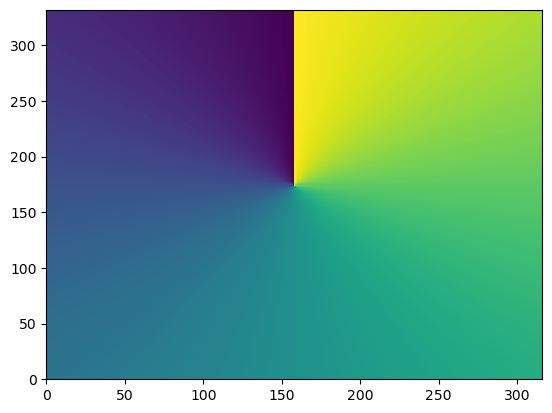

In [55]:
# create a retangular grid with dimension of the data 1440, 120
# lat, lon = np.meshgrid(ds['latitude'].values, ds['longitude'].values)

# # transformer converts lon and lat values to x, y 
# x, y= transformer.transform(lat, lon) #1440, 120
# x.shape

X, Y = np.meshgrid(ds.xgrid, ds.ygrid)
lat, lon = transformer.transform(X, Y)

plt.pcolormesh(lon)


In [56]:
ds.cdr_seaice_conc_monthly[0][:].dims

('ygrid', 'xgrid')

In [57]:
ds.coords['lat'] = (ds.cdr_seaice_conc_monthly[0][:].dims, lat)
ds.coords['lon'] = (ds.cdr_seaice_conc_monthly[0][:].dims, lon)

ds.cdr_seaice_conc_monthly

<xarray.DataArray 'cdr_seaice_conc_monthly' (time: 1, ygrid: 332, xgrid: 316)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01
  * ygrid    (ygrid) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
  * xgrid    (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
    lat      (ygrid, xgrid) float64 -39.5 -39.62 -39.75 ... -41.98 -41.85 -41.71
    lon      (ygrid, xgrid) float64 -42.23 -42.05 -41.87 ... 135.4 135.2 135.0
Attributes: (12/13)
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    colorBarMaximum:      1.0
    colorBarMinimum:      0.0
    colorBarPalette:      KT_ice
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    ...                   ...
    ioos_category:        Ice Distribution
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    references:           https://nsidc.org/data/g02202/versions/4/
    standard_name:        sea_ice_area_fraction
    units:                1
    valid_range:          [0. 1.]

In [46]:
np.min(lat)

39.36392379066604

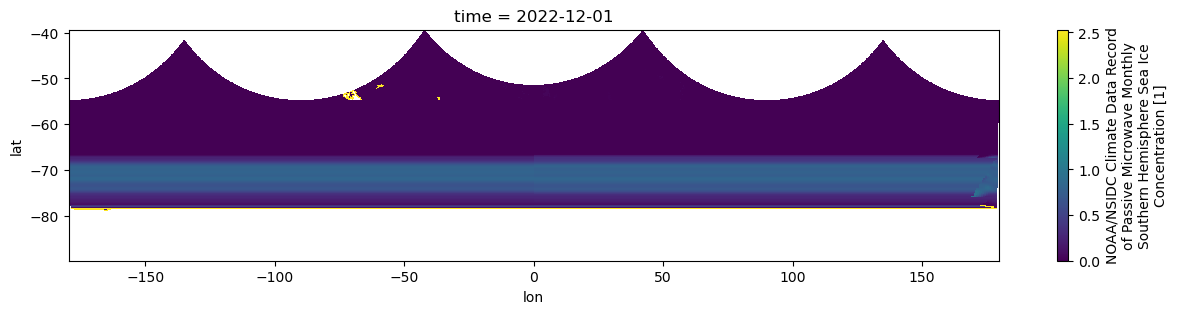

In [58]:
plt.figure(figsize=(15,3))
ds.cdr_seaice_conc_monthly[0][:].plot.pcolormesh('lon', 'lat')

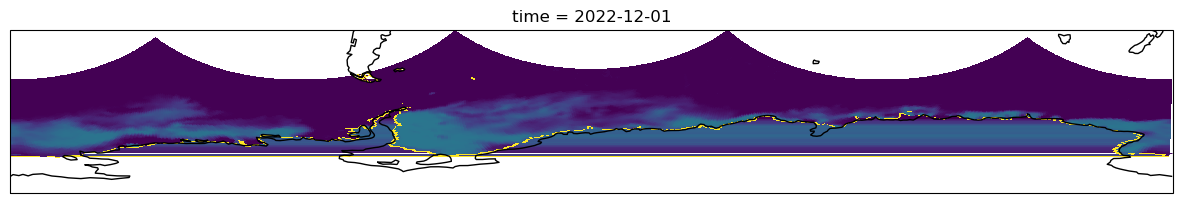

In [59]:
plt.figure(figsize=(15,3))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.cdr_seaice_conc_monthly[0][:].plot.pcolormesh('lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

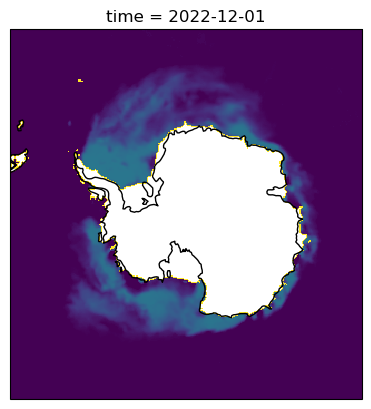

In [60]:
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ds.cdr_seaice_conc_monthly[0][:].plot.pcolormesh('lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()